In [1]:
from contextlib import suppress
from random import random, randrange
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from faker import Faker
from gensim.models import Word2Vec
from tqdm import tqdm
import tensorflow as tf
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from string2image.generate import Generator
from string2image.preprocessing import String2Image
from tensorflow.keras import datasets, layers, models

#### Let's load our data generator and previously trained Word2Vec model trained on characters in the dataset.

In [2]:
fake = Faker()
data_sources = [
    fake.first_name,
    fake.last_name,
    fake.phone_number,
    fake.company,
    fake.address,
    fake.ssn,
]
g = Generator(data_sources)

w2v_model = Word2Vec.load("word2vec.model")

#### Now we can set up some training and testing data with our generator class
Some sample data is shown, note we're using nested namedtuples to organize the values and labels.

In [3]:
size = 2000
# When including the reverse 
train_data = list(g.random_pair_gen(size, include_reverse=True))
test_data = list(g.random_pair_gen(size, include_reverse=True))
# Sloppy way of ensuring out test data does not appear in our train data
test_data = [d for d in test_data if d not in train_data]
# Ensure there are enough testing samples left.
print(len(test_data))

3996


#### Here's a visual of what the features look like
`String2Image` takes in a string to encode and resize the respective string image array. The subtraction operation for this class will perform numpy array subtraction.

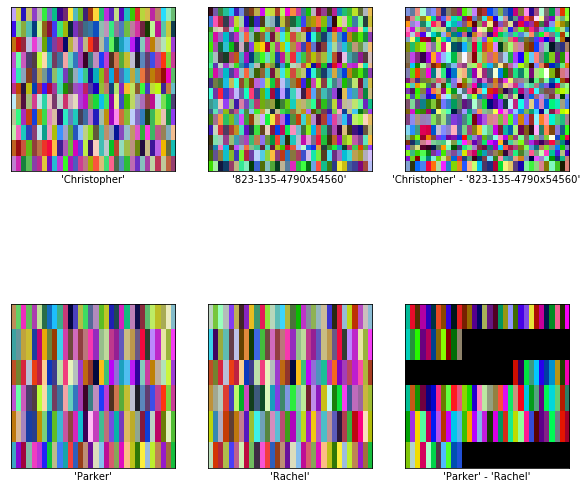

In [4]:
s1 = String2Image('Christopher', w2v_model, array_size=(32, 32), flatten=False, mode="RGB")
s2 = String2Image('823-135-4790x54560', w2v_model, array_size=(32, 32), flatten=False, mode="RGB")

s3 = String2Image('Parker', w2v_model, array_size=(32, 32), flatten=False, mode="RGB")
s4 = String2Image('Rachel', w2v_model, array_size=(32, 32), flatten=False, mode="RGB")

to_plot = [s1.array, s2.array, s1 - s2, s3.array, s4.array, s3 - s4]
labels = [f"'{s1.s}'", f"'{s2.s}'", f"'{s1.s}' - '{s2.s}'", f"'{s3.s}'", f"'{s4.s}'", f"'{s3.s}' - '{s4.s}'"]
plt.figure(figsize=(10,10))
for i, (a, l) in enumerate(zip(to_plot, labels)):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(a, cmap=plt.cm.binary)
    plt.xlabel(l)
plt.show()

It's somewhat noticeable that the first operation produces a noisy image after subtraction and the second operation result is more uniform. There's even some black when the 'a' and 'e' are cancelled out. There are many factors at play here but we are hoping trained CNN can cut through the noise and classify strings as similar based on patterns we can't explain easily.

#### We can define and call some functions to transform our data set to their respective difference images.

In [5]:
def get_features(s1, s2, model):
    left = String2Image(s1, model, array_size=(32, 32), flatten=False, mode="RGB")
    right = String2Image(s2, model, array_size=(32, 32), flatten=False, mode="RGB")
    return left - right

def arrange_values(data):
    data = map(lambda x: get_features(x.left.value, x.right.value, w2v_model), data)
    data = np.array(list(data))
    return data

def arrange_labels(labels):
    labels = map(lambda x: np.array(np.int(x.is_match)).reshape(1,), labels)
    labels = np.array(list(labels))
    return labels

train_images, test_images = arrange_values(train_data), arrange_values(test_data)
train_labels, test_labels = arrange_labels(train_data), arrange_labels(test_data)

# train_images = np.array(list(map(lambda x: get_features(x.left.value, x.right.value, w2v_model), train_data)))
# train_labels = np.array(list(map(lambda x: np.array(np.int(x.is_match)).reshape(1,), train_data)))

# test_images = np.array(list(map(lambda x: get_features(x.left.value, x.right.value, w2v_model), test_data)))
# test_labels = np.array(list(map(lambda x: np.array(np.int(x.is_match)).reshape(1,), test_data)))

train_images, test_images = train_images / 255.0, test_images / 255.0

#### Verify our 'images'
*Now and going forward we will use a lot of the code found in the Keras CNN tutorial https://www.tensorflow.org/tutorials/images/cnn*

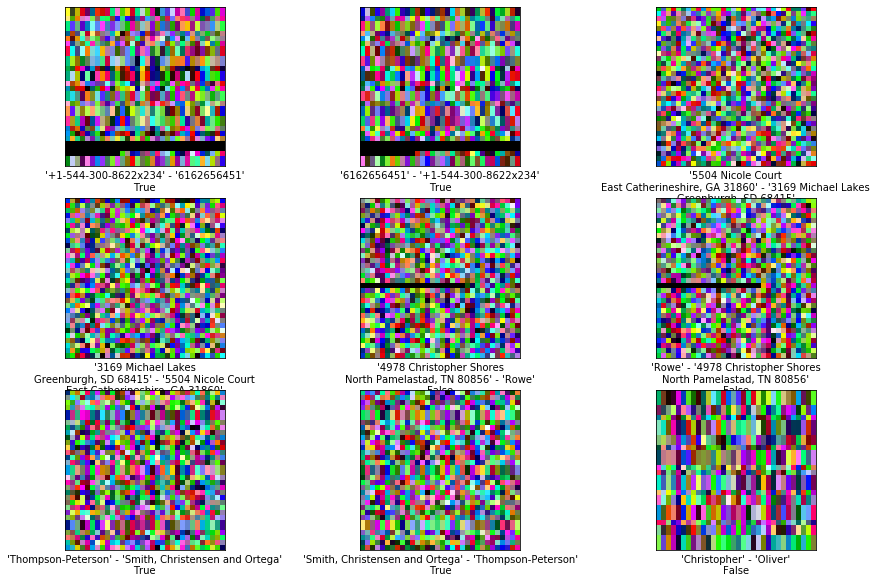

In [6]:
class_names = [True, False]

plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    label = f"'{train_data[i].left.value}' - '{train_data[i].right.value}'\n{train_data[i].is_match}"
    plt.xlabel(label)
plt.show()

### Create the convolutional base and add Dense layers

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

#### Compile and train the model

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))


Epoch 1/10
125/125 [==============================] - 1s 7ms/step - loss: 0.6173 - accuracy: 0.6518 - val_loss: 0.5262 - val_accuracy: 0.7407
Epoch 2/10
125/125 [==============================] - 1s 5ms/step - loss: 0.4918 - accuracy: 0.7595 - val_loss: 0.4659 - val_accuracy: 0.7655
Epoch 3/10
125/125 [==============================] - 1s 5ms/step - loss: 0.4432 - accuracy: 0.7828 - val_loss: 0.4266 - val_accuracy: 0.7888
Epoch 4/10
125/125 [==============================] - 1s 5ms/step - loss: 0.4177 - accuracy: 0.8040 - val_loss: 0.4129 - val_accuracy: 0.7988
Epoch 5/10
125/125 [==============================] - 1s 5ms/step - loss: 0.3743 - accuracy: 0.8227 - val_loss: 0.4172 - val_accuracy: 0.7985
Epoch 6/10
125/125 [==============================] - 1s 5ms/step - loss: 0.3213 - accuracy: 0.8580 - val_loss: 0.4082 - val_accuracy: 0.7978
Epoch 7/10
125/125 [==============================] - 1s 5ms/step - loss: 0.2662 - accuracy: 0.8863 - val_loss: 0.3876 - val_accuracy: 0.8341
Epoch 

#### Evaluate the model

125/125 - 0s - loss: 0.5630 - accuracy: 0.8331


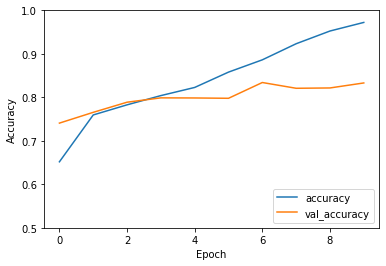

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

#### At this model's conclusion we attained a good level of accuracy, let's dig a little deeper into those results and see which comparisons the models performed best (and worst) on.

We're only going to measure `false` comparisons since `true` comparison accuracy will be skewed by the respective false positive combination *e.g. incorrectly classified last-first name comparisons will be tucked away in first-first comparisons*

Scoring combinations offirst_name,last_name,phone_number,company,address,ssn


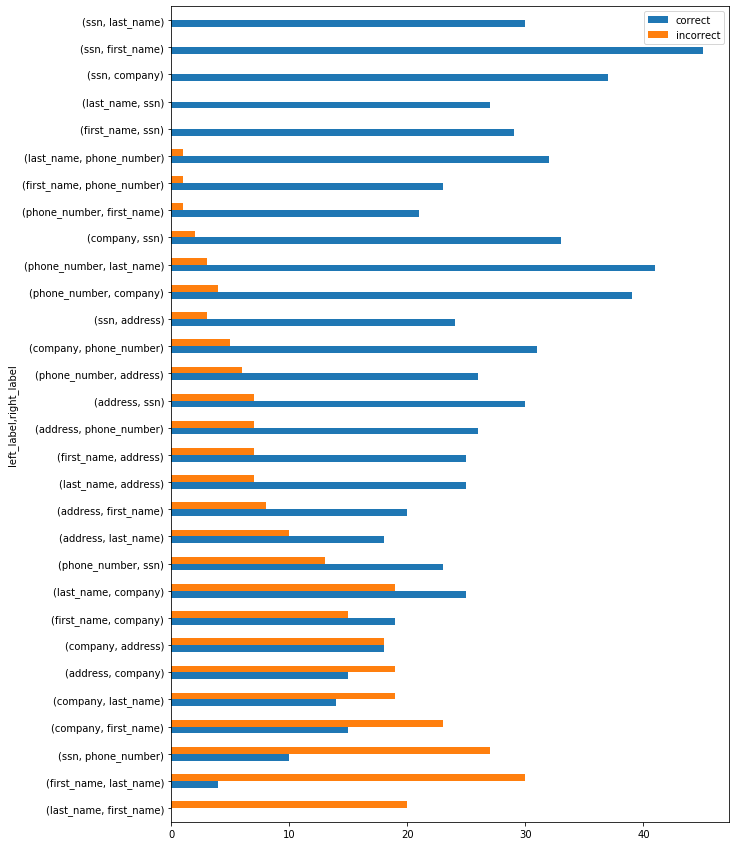

In [10]:
size = 1000
real_test = list(g.random_pair_gen(size, is_match=False))
# real_test = test_data
real_test_images = arrange_values(real_test)  / 255.0
test_df = pd.DataFrame(model.predict(real_test_images))

examine = pd.DataFrame(real_test)
examine["val"] = (test_df[0] < 1)
examine["left_label"] = examine["left"].map(lambda x: x.label)
examine["right_label"] = examine["right"].map(lambda x: x.label)
examine["correct"] = examine["val"] == examine["is_match"]
examine["incorrect"] = examine["val"] != examine["is_match"]
grouped = examine.groupby(["left_label", "right_label"])[["correct", "incorrect"]].sum()
grouped["ratio"] = (grouped["incorrect"] / grouped["correct"])
print("Scoring combinations of" + ",".join(map(lambda x: x.__name__, data_sources)))
grouped.sort_values("ratio", ascending=False)[["correct", "incorrect"]].plot.barh(figsize=(10,15))